In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from datetime import datetime

C:\Users\Loveshant\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#importing the Dataset
df_aquatic_toxicity = pd.read_csv('qsar_aquatic_toxicity.csv',sep=';',names=["TPSA(Tot)","SAacc","H-050","MLOGP","RDCHI","GATS1p","nN","C-040","LC50"])

In [3]:
# A clean dataset with no NULL values and all numeric values
print(df_aquatic_toxicity.isnull().sum())
df_aquatic_toxicity.info()

TPSA(Tot)    0
SAacc        0
H-050        0
MLOGP        0
RDCHI        0
GATS1p       0
nN           0
C-040        0
LC50         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 9 columns):
TPSA(Tot)    546 non-null float64
SAacc        546 non-null float64
H-050        546 non-null int64
MLOGP        546 non-null float64
RDCHI        546 non-null float64
GATS1p       546 non-null float64
nN           546 non-null int64
C-040        546 non-null int64
LC50         546 non-null float64
dtypes: float64(6), int64(3)
memory usage: 38.5 KB


In [4]:
df_aquatic_toxicity.head()

,TPSA(Tot),SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,LC50
0,0.00,0.0,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.0,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.0,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.0,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.0,0,4.068,2.758,0.695,0,0,5.979


In [5]:
df_aquatic_toxicity.tail()

,TPSA(Tot),SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,LC50
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995
545,0.00,0.000,0,2.255,1.800,0.917,0,0,2.480


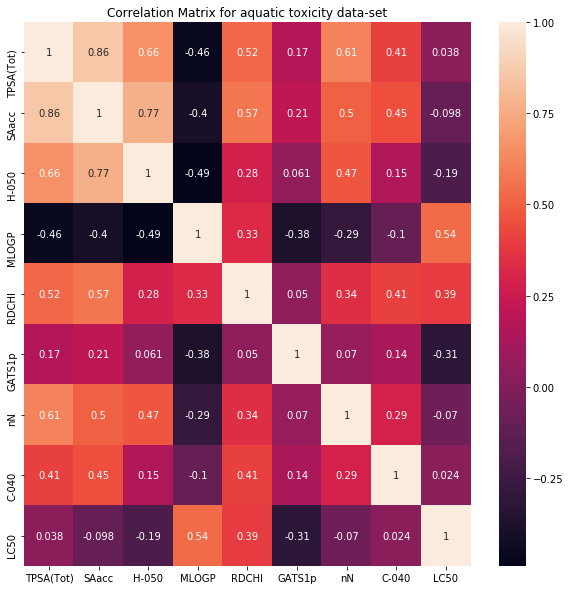

In [6]:
#Analysing Correlation between various features of the aquatic toxicity dataset
aquatic_toxicity_corr = df_aquatic_toxicity.corr()
figure, ax = plt.subplots(figsize = (10,10))
ax.set_title('Correlation Matrix for aquatic toxicity data-set')
matrix = sns.heatmap(aquatic_toxicity_corr,ax=ax, annot= True)

In [7]:
#Feature Selection by dropping features having correlation less than 0.05 with target variable quality
abs_val_aquatic_toxicity_corr = aquatic_toxicity_corr['LC50'].drop('LC50').abs()
imp_feature_idx = abs_val_aquatic_toxicity_corr[abs_val_aquatic_toxicity_corr > 0.05].index.values.tolist()

In [8]:
#Preparing the final dataset
x = df_aquatic_toxicity[imp_feature_idx] 
y = df_aquatic_toxicity['LC50']

In [9]:
#Creating Traning and test set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=0)

In [10]:
#Standardizing the prepared training and test data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
def svr_param_selection(X, y, nfolds):
    Kernels = ['linear', 'poly', 'rbf']
    Cs = [0.001, 0.01, 0.1, 1]
    Gammas = [0.001, 0.01, 0.1]
    param_grid = {'kernel':Kernels, 'C': Cs, 'gamma' : Gammas}
    grid_search = GridSearchCV(SVR(), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('SVR Lowest MSE Score: '+str(grid_search.best_score_))
    print('SVR With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [12]:
def random_forest_regressor_param_selection(X, y, nfolds):
    Estimators = np.arange(1,100,15)
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'n_estimators': Estimators, 'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('RandomForestRegressor Lowest MSE Score: '+str(grid_search.best_score_))
    print('RandomForestRegressor With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [13]:
def decision_tree_regressor_param_selection(X, y, nfolds):
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('DecisionTreeRegressor Lowest MSE Score: '+str(grid_search.best_score_))
    print('DecisionTreeRegressor With Parameters: '+str(grid_search.best_params_))    
    return grid_search.best_params_

In [14]:
def ada_boost_regressor_param_selection(X, y, nfolds):
    Estimators = np.arange(1,100,15)
    Learning_rates = [0.01,0.05,0.1,0.3]
    Losses = ['linear', 'square', 'exponential']
    param_grid = {'n_estimators': Estimators, 'learning_rate': Learning_rates, 'loss': Losses}
    grid_search = GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('AdaBoostRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('AdaBoostRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [15]:
def gaussian_regressor_param_selection(X, y, nfolds):
    kernel_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
    kernel_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
    kernel_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
    Kernels = [kernel_rbf, kernel_rq]
    param_grid = {'kernel': Kernels}
    grid_search = GridSearchCV(GaussianProcessRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('GaussianRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('GaussianRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [16]:
def linear_regressor_param_selection(X, y, nfolds):
    param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('LinearRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('LinearRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [17]:
def neural_network_regressor_param_selection(X, y, nfolds):
    Learning_rates = ['constant','adaptive']
    Learning_rates_init = [0.001, 0.01, 0.1, 0.3]
    Hidden_Layer_Sizes = [1, 5, 10, (5,5), (10,5)]
    Activations = ['logistic', 'tanh', 'relu']
    Alphas = [0.0001,0.002]
    param_grid = {'learning_rate': Learning_rates, 'learning_rate_init': Learning_rates_init, 'hidden_layer_sizes': Hidden_Layer_Sizes, 'activation': Activations, 'alpha': Alphas}
    grid_search = GridSearchCV(MLPRegressor(max_iter=900), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    print('NeuralNetworkRegressor Lowest MSE Score:'+str(grid_search.best_score_))
    print('NeuralNetworkRegressor With Parameters:'+str(grid_search.best_params_))    
    return grid_search.best_params_

In [18]:
#Using the 3-Fold HyperParam Search to evaluate the best hyperparams for each model
print("now ="+str(datetime.now()))
svr_best_param           = svr_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
random_forest_best_param = random_forest_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
decision_tree_best_param = decision_tree_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
ada_boost_best_param     = ada_boost_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
linear_best_param         = linear_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))
neural_network_best_param = neural_network_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))


now =2019-12-06 18:12:34.216200
SVR Lowest MSE Score: 0.41907102558228887
SVR With Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
now =2019-12-06 18:12:51.769331
RandomForestRegressor Lowest MSE Score: 0.49159993831886084
RandomForestRegressor With Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'n_estimators': 61}
now =2019-12-06 18:13:17.741182
DecisionTreeRegressor Lowest MSE Score: 0.3371764673707277
DecisionTreeRegressor With Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 0.05}
now =2019-12-06 18:13:33.241238
AdaBoostRegressor Lowest MSE Score:0.49993006916435734
AdaBoostRegressor With Parameters:{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 31}
now =2019-12-06 18:14:02.878235
LinearRegressor Lowest MSE Score:0.39552936263224786
LinearRegressor With Parameters:{'copy_X': True, 'fit_intercept': True, 'normalize': True}
now =2019-12-06 18:14:21.241642
NeuralNetworkRegressor Lowest MSE Score:0.442970843810184
NeuralNetworkRegressor With Parame

In [19]:
gaussian_best_param       = gaussian_regressor_param_selection(x_train_scaled, y_train, 3)
print("now ="+str(datetime.now()))

GaussianRegressor Lowest MSE Score:0.4756977963819313
GaussianRegressor With Parameters:{'kernel': 1**2 * RationalQuadratic(alpha=0.1, length_scale=1)}
now =2019-12-06 18:17:56.247334


C:\Users\Loveshant\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5084.82691753,   771.27262184]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [21]:
best_svr = SVR(C=1, gamma=0.1, kernel='rbf')
best_svr.fit(x_train_scaled, y_train)
y_pred = best_svr.predict(x_test_scaled)
print('MSE for SVR: '+str(mean_squared_error(y_test, y_pred)))


MSE for SVR: 1.7511001986669095


In [23]:
best_decision_tree_regressor = DecisionTreeRegressor(max_features='sqrt', min_samples_leaf=0.05, random_state=0)
best_decision_tree_regressor.fit(x_train_scaled, y_train)
y_pred = best_decision_tree_regressor.predict(x_test_scaled)
print('MSE for Decision Tree Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Decision Tree Regressor: 2.037431998402202


In [24]:
best_random_forest_regressor = RandomForestRegressor(max_features='sqrt', min_samples_leaf=0.01, n_estimators=61, random_state=0)
best_random_forest_regressor.fit(x_train_scaled, y_train)
y_pred = best_random_forest_regressor.predict(x_test_scaled)
print('MSE for Random Forest Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Random Forest Regressor: 1.6563803646437563


In [25]:
best_ada_boost_regressor = AdaBoostRegressor(learning_rate=0.1, loss='linear', n_estimators=31, random_state=0)
best_ada_boost_regressor.fit(x_train_scaled, y_train)
y_pred = best_ada_boost_regressor.predict(x_test_scaled)
print('MSE for AdaBoost Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for AdaBoost Regressor: 1.7097962573250063


In [26]:
best_linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
best_linear_regressor.fit(x_train_scaled, y_train)
y_pred = best_linear_regressor.predict(x_test_scaled)
print('MSE for Linear Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Linear Regressor: 1.7211188166775946


In [27]:
best_neural_network_regressor = MLPRegressor(activation='tanh', alpha=0.0001, hidden_layer_sizes=10, learning_rate='constant', learning_rate_init=0.01, random_state=0)
best_neural_network_regressor.fit(x_train_scaled, y_train)
y_pred = best_neural_network_regressor.predict(x_test_scaled)
print('MSE for Neural Network Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Neural Network Regressor: 1.7380615059158095


C:\Users\Loveshant\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [28]:
best_gaussian_regressor = GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1))
best_gaussian_regressor.fit(x_train_scaled, y_train)
y_pred = best_gaussian_regressor.predict(x_test_scaled)
print('MSE for Gaussian Regressor: '+str(mean_squared_error(y_test, y_pred)))

MSE for Gaussian Regressor: 1.5927997382325982
